<a href="https://colab.research.google.com/github/Muhammad-ismail2134/CODSOFT/blob/main/MoviePredictionWithDeepLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task 01 Movie Genre Classification
>Note: This notebook is part of my internship

## Importing Libaraies


In [ ]:
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow as tf

from sklearn.model_selection import train_test_split
from ast import literal_eval

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [ ]:
!pip install kaggle

In [ ]:
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json

## Downloading Dataset from Kaggle

In [ ]:
!kaggle datasets download -d jrobischon/wikipedia-movie-plots

wikipedia-movie-plots.zip: Skipping, found more recently modified local copy (use --force to force download)


## unizipping


In [ ]:
import zipfile

#Unzipping dataset from kaggle
local_zip = './wikipedia-movie-plots.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('./wikipedia-movie-plots')

In [ ]:
movies = pd.read_csv('/content/wikipedia-movie-plots/wiki_movie_plots_deduped.csv')

## Dataset Preview

In [ ]:
movies.head()

,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot
0,1901,Kansas Saloon Smashers,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Kansas_Saloon_Sm...,"A bartender is working at a saloon, serving dr..."
1,1901,Love by the Light of the Moon,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Love_by_the_Ligh...,"The moon, painted with a smiling face hangs ov..."
2,1901,The Martyred Presidents,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/The_Martyred_Pre...,"The film, just over a minute long, is composed..."
3,1901,"Terrible Teddy, the Grizzly King",American,Unknown,NaN,unknown,"https://en.wikipedia.org/wiki/Terrible_Teddy,_...",Lasting just 61 seconds and consisting of two ...
4,1902,Jack and the Beanstalk,American,"George S. Fleming, Edwin S. Porter",NaN,unknown,https://en.wikipedia.org/wiki/Jack_and_the_Bea...,The earliest known adaptation of the classic f...


In [ ]:
print(movies.shape[0])

34886


## Droping Null Rows


In [ ]:
movies = movies[movies['Genre'] != 'unknown']
movies.dropna(inplace=True)
print(movies.shape[0])

28064


In [ ]:
import re
def clean_text(text):
    # remove backslash-apostrophe
    text = re.sub("\'", "", text)
    # remove everything alphabets
    text = re.sub("[^a-zA-Z]"," ",text)
    # remove whitespaces
    text = ' '.join(text.split())
    # convert text to lowercase
    text = text.lower()

    return text


## Cleaning movie plots

In [ ]:
movies['clean_plot'] = movies['Plot'].apply(lambda x: clean_text(x))

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

# function to remove stopwords
def remove_stopwords(text):
    no_stopword_text = [w for w in text.split() if not w in stop_words]
    return ' '.join(no_stopword_text)

movies['clean_plot'] = movies['clean_plot'].apply(lambda x: remove_stopwords(x))

In [ ]:
movies['Genre'] = movies['Genre'].str.replace('/', ' ')
movies['Genre'] = movies['Genre'].str.replace(r'\bfilm\b', '',regex=True)
movies['Genre'] = movies['Genre'].str.replace(',', '')

# Strip leading and trailing whitespace
movies['Genre'] = movies['Genre'].str.strip()

In [ ]:
movies['Genre'][500:510]

566               drama
567             western
568             western
569               crime
570             fantasy
571              horror
572           adventure
573      romantic drama
574    mystery thriller
575              comedy
Name: Genre, dtype: object

In [ ]:
movies = movies[movies['Genre'].str.len()>0]
print(movies.shape[0])

28046


In [ ]:
def split_genre(genre_str):
    return genre_str.split()[:2]

# Apply the function to create a new column with lists
movies['Genre_list'] = movies['Genre'].apply(split_genre)

In [ ]:
movies = movies[~movies["Title"].duplicated()]
print(f"There are {len(movies)} rows in the deduplicated dataset.")

# There are some terms with occurrence as low as 1.
print(sum(movies["Genre_list"].value_counts() == 1))


There are 26387 rows in the deduplicated dataset.
562


## Using stratified splits because of class imbalance

In [ ]:
# Droping singular classes
class_counts = movies['Genre_list'].value_counts()

# Identify classes with only one entity
classes_to_drop = class_counts[class_counts == 1].index


In [ ]:
print(len(classes_to_drop))
print(classes_to_drop[560:562])

562
Index([['romance', 'science'], ['comedic', 'drama']], dtype='object')


In [ ]:
filtered_movies = movies[~movies['Genre_list'].isin(classes_to_drop)]

In [ ]:
filtered_movies.shape[0]

25825

In [ ]:
test_split = 0.1

# Initial train and test split.
train_df, test_df = train_test_split(
    filtered_movies,
    test_size=test_split,
    stratify=filtered_movies["Genre_list"].values,
)

# Splitting the test set further into validation
# and new test sets.
val_df = test_df.sample(frac=0.5)
test_df.drop(val_df.index, inplace=True)

print(f"Number of rows in training set: {len(train_df)}")
print(f"Number of rows in validation set: {len(val_df)}")
print(f"Number of rows in test set: {len(test_df)}")

Number of rows in training set: 23242
Number of rows in validation set: 1292
Number of rows in test set: 1291


## Multi-label binarization


In [ ]:
genres = tf.ragged.constant(train_df["Genre_list"].values)
lookup = tf.keras.layers.StringLookup(output_mode="multi_hot")
lookup.adapt(genres)
vocab = lookup.get_vocabulary()


def invert_multi_hot(encoded_labels):
    """Reverse a single multi-hot encoded label to a tuple of vocab terms."""
    hot_indices = np.argwhere(encoded_labels == 1.0)[..., 0]
    return np.take(vocab, hot_indices)


print("Vocabulary:\n")
print(vocab)

Vocabulary:

['[UNK]', 'drama', 'comedy', 'action', 'romance', 'thriller', 'crime', 'horror', 'western', 'musical', 'adventure', 'romantic', 'war', 'family', 'science', 'fiction', 'mystery', 'fantasy', 'noir', 'sci-fi', 'biography', 'animation', 'animated', 'social', 'historical', 'comedy-drama', 'short', 'suspense', 'spy', 'world', 'sports', 'martial', 'serial', 'biopic', 'superhero', 'arts', 'documentary', 'black', 'political', 'anime', 'biographical', 'mockumentary', 'melodrama', 'psychological', 'satire', 'masala', 'dramedy', 'tokusatsu', 'epic', 'costume', 'mythology', 'disaster', 'adult', 'supernatural', 'slasher', 'kung', 'folklore', 'teen', 'period', 'parody', 'dark', 'slapstick', 'children', 'subject', 'sex', 'science-fiction', 'rom', 'fu', 'feature', 'devotional', 'com', 'action-adventure', 'literary', 'history', 'erotic', 'docudrama', "children's", 'bio-pic', 'anthology', '-', 'swashbuckler', 'screwball', 'romantic-comedy', 'detective', 'wuxia', 'exploitation', 'dance', 'sex

In [ ]:
sample_label = train_df["Genre_list"].iloc[3]
print(f"Original label: {sample_label}")

label_binarized = lookup([sample_label])
print(f"Label-binarized representation: {label_binarized}")

Original label: ['comedy', 'romance']
Label-binarized representation: [[0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


## Making Datasets


In [ ]:
train_df["clean_plot"].apply(lambda x: len(x.split(" "))).describe()

count    23242.000000
mean       214.499656
std        171.606260
min          2.000000
25%         73.000000
50%        173.000000
75%        333.000000
max       2788.000000
Name: clean_plot, dtype: float64

In [ ]:
max_seqlen = 300
batch_size = 128
padding_token = "<pad>"
auto = tf.data.AUTOTUNE


def make_dataset(dataframe, is_train=True):
    labels = tf.ragged.constant(dataframe["Genre_list"].values)
    label_binarized = lookup(labels).numpy()
    dataset = tf.data.Dataset.from_tensor_slices(
        (dataframe["clean_plot"].values, label_binarized)
    )
    dataset = dataset.shuffle(batch_size * 10) if is_train else dataset
    return dataset.batch(batch_size)

In [ ]:
train_dataset = make_dataset(train_df, is_train=True)
validation_dataset = make_dataset(val_df, is_train=False)
test_dataset = make_dataset(test_df, is_train=False)

## Dataset preview

In [ ]:
text_batch, label_batch = next(iter(train_dataset))

for i, text in enumerate(text_batch[:5]):
    label = label_batch[i].numpy()[None, ...]
    print(f"Abstract: {text}")
    print(f"Label(s): {invert_multi_hot(label[0])}")
    print(" ")

Abstract: b'earl burnstead roland young gambles away eminently correct english manservant marmaduke ruggles charles laughton ruggles new masters crude nouveau riche american millionaires egbert effie floud charlie ruggles mary boland bring ruggles back red gap washington remote western boomtown ruggles mistaken wealthy retired englishman colonel becomes celebrity small town ruggles attempts adjust rough new community learns live life terms achieving fulfilling independence result easily missed bit irony ruggles bemoans fate relegated america land slavery obvious laughtons character sold easily negro antebellum south climax film laughton recitation gettysburg address saloon filled rough western characters held spellbound speech newly imbued spirit democracy self determination ruggles becomes man giving previous employment opening restaurant red gap'
Label(s): ['comedy']
 
Abstract: b'film takes place judea fictional village near jerusalem protagonist joel elder son village rabbi lamech 

*Simply lovely*

In [ ]:
vocabulary = set()
train_df["clean_plot"].str.lower().str.split().apply(vocabulary.update)
vocabulary_size = len(vocabulary)
print(vocabulary_size)

121176


### Creating Vectorization layer

In [ ]:
text_vectorizer = layers.TextVectorization(
    max_tokens=vocabulary_size, ngrams=2, output_mode="tf_idf"
)

with tf.device("/CPU:0"):
    text_vectorizer.adapt(train_dataset.map(lambda text, label: text))

train_dataset = train_dataset.map(
    lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto
).prefetch(auto)
validation_dataset = validation_dataset.map(
    lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto
).prefetch(auto)
test_dataset = test_dataset.map(
    lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto
).prefetch(auto)

## Make Text Classification Model

In [ ]:
def make_model():
    shallow_mlp_model = keras.Sequential(
        [
            layers.Dense(512, activation="relu"),
            layers.Dense(256, activation="relu"),
            layers.Dense(lookup.vocabulary_size(), activation="sigmoid"),
        ]
    )
    return shallow_mlp_model

In [ ]:
epochs = 5

shallow_mlp_model = make_model()
shallow_mlp_model.compile(
    loss="binary_crossentropy", optimizer="adam", metrics=["binary_accuracy"]
)

history = shallow_mlp_model.fit(
    train_dataset, validation_data=validation_dataset, epochs=epochs
)

Epoch 1/5
182/182 [==============================] - 326s 2s/step - loss: 0.0649 - binary_accuracy: 0.9863 - val_loss: 0.0249 - val_binary_accuracy: 0.9938
Epoch 2/5
182/182 [==============================] - 318s 2s/step - loss: 0.0081 - binary_accuracy: 0.9978 - val_loss: 0.0261 - val_binary_accuracy: 0.9939
Epoch 3/5
182/182 [==============================] - 336s 2s/step - loss: 0.0028 - binary_accuracy: 0.9993 - val_loss: 0.0318 - val_binary_accuracy: 0.9940
Epoch 4/5
182/182 [==============================] - 341s 2s/step - loss: 0.0014 - binary_accuracy: 0.9997 - val_loss: 0.0363 - val_binary_accuracy: 0.9941
Epoch 5/5
182/182 [==============================] - 321s 2s/step - loss: 8.9616e-04 - binary_accuracy: 0.9998 - val_loss: 0.0393 - val_binary_accuracy: 0.9940


## Model Evaluation

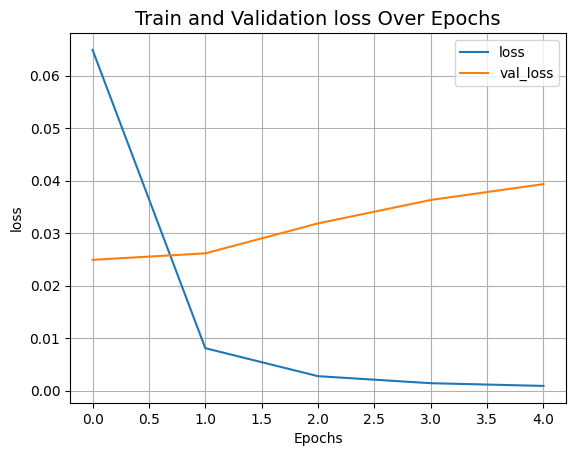

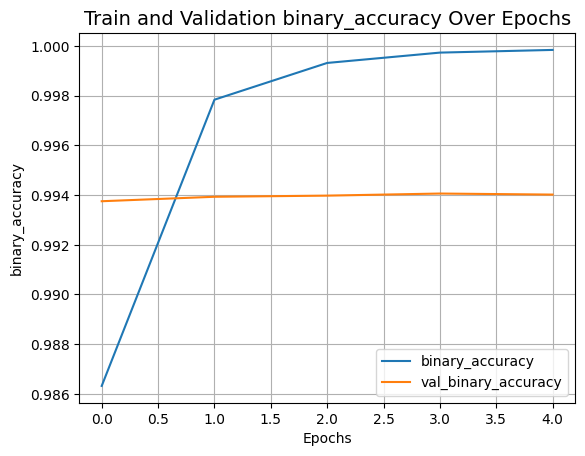

In [ ]:

def plot_result(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_result("loss")
plot_result("binary_accuracy")

In [ ]:
_, binary_acc = shallow_mlp_model.evaluate(test_dataset)
print(f"Categorical accuracy on the test set: {round(binary_acc * 100, 2)}%.")

11/11 [==============================] - 4s 310ms/step - loss: 0.0412 - binary_accuracy: 0.9939
Categorical accuracy on the test set: 99.39%.


In [ ]:
model_for_inference = keras.Sequential([text_vectorizer, shallow_mlp_model])

# Create a small dataset just for demoing inference.
inference_dataset = make_dataset(test_df.sample(100), is_train=False)
text_batch, label_batch = next(iter(inference_dataset))
predicted_probabilities = model_for_inference.predict(text_batch)

# Perform inference.
for i, text in enumerate(text_batch[:15]):
    label = label_batch[i].numpy()[None, ...]
    print(f"Abstract: {text}")
    print(f"Label(s): {invert_multi_hot(label[0])}")
    predicted_proba = [proba for proba in predicted_probabilities[i]]
    top_3_labels = [
        x
        for _, x in sorted(
            zip(predicted_probabilities[i], lookup.get_vocabulary()),
            key=lambda pair: pair[0],
            reverse=True,
        )
    ][:3]
    print(f"Predicted Label(s): ({', '.join([label for label in top_3_labels])})")
    print(" ")

4/4 [==============================] - 1s 95ms/step
Abstract: b'john bradshaw robert griffith young naval officer attends lunchtime concert westminster central hall meets reverend peter britton g h mulcaster daughter katherine brook concert three share taxi seeing father train conference katherine agrees tea john enjoy others company later go see film followed dinner stroll along thames embankment john impulsively tells katherine fallen love reminds hardly know one another since brothers death far east devote father couple finally part agreeing meet following day however katherine receives telegram hotel stating brother dennis hanley turned alive arriving home next day returns home early next morning leaving note explanation john unfortunately john forgets name katherines hotel receive note distraught fails turn rendezvous meanwhile back home katherine finds dennis accompanied max borrow manning whiley old admirer still wants marry sustained serious eye injuries saving dennis life kath